## Tunning dos hiperparâmetros
- Será realizado o tunning para os seguintes casos:
    1) sem informações do WHOQOL na base
    2) com todas as respostas do WHOQOL
    3) só com o índice final do WHOQOL
    4) só com os índices dos domínios do WHOQOL

- Para os seguintes modelos:
    1) Random Forest
    2) SVM
    3) MLP
    4) XGBoost

#### Workflow:
Para cada caso:
- Importar dados
- Separar em treino e teste ( Preciso
- Definir os parâmetros a serem testados
- Realizar o tunning
- Salvar os resultados graficamente
- Salvar o melhor modelo

### Importando as bibliotecas

In [1]:
!pip install seaborn

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns

#Importando modelo Dummy:
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings('ignore')

In [7]:
import pickle


### Definindo a função

In [8]:

def perform_model_tuning(data, target, models, param_grids, base_name):
    # Dividir os dados em treinamento e teste após o Random Under-Sampling
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    best_models = {}  # Dicionário para armazenar o melhor modelo de cada tipo
    model_accuracies = {}  # Dicionário para armazenar as acurácias de cada modelo
    current_dir = os.getcwd()
    for model_name, model, param_grid_entry in zip(models.keys(), models.values(), param_grids):
        print(f"Tuning do modelo {model_name} iniciado...")

        # Acessar o dicionário de parâmetros correspondente ao modelo atual
        param_grid = param_grid_entry['params']

        # Realizar a busca em grid para encontrar os melhores parâmetros
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        # Melhor modelo encontrado
        best_model = grid_search.best_estimator_

        # Fazer previsões no conjunto de teste
        y_pred = best_model.predict(X_test)

        # Calcular a acurácia do modelo
        accuracy = accuracy_score(y_test, y_pred)
        model_accuracies[model_name] = accuracy

        print(f"Acurácia do modelo {model_name}: {accuracy:.4f}")

        # Salvar o melhor modelo
        best_models[model_name] = best_model

    # Plotar gráfico de desempenho comparativo
    plt.figure(figsize=(10, 6))
    plt.bar(model_accuracies.keys(), model_accuracies.values())
    plt.xlabel('Modelos')
    plt.ylabel('Acurácia')
    plt.title('Comparação de desempenho dos modelos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    graph_filename = f"{base_name}_graph_{model_name}.png"
    graph_path = os.path.join(current_dir, graph_filename)
    plt.savefig(graph_path)
    plt.close()


    #Pickle the single best model, verifying the best and saving from best_models dict, se tiver mais algo salvo com o mesmo nome, adiciona mais um.
    best_model = max(model_accuracies, key=model_accuracies.get)
    best_model = best_models[best_model]
    if os.path.exists(f"{base_name}_best_model.pkl"):
        i = 1
        while os.path.exists(f"{base_name}_best_model_{i}.pkl"):
            i += 1
        pickle.dump(best_model, open(f"{base_name}_best_model_{i}.pkl", "wb"))
    else:
        pickle.dump(best_model, open(f"{base_name}_best_model.pkl", "wb"))
    # Salvar tabela com os valores de acurácia
    table_filename = f"{base_name}_table_{model_name}.csv"
    accuracies_df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['Acurácia'])
    table_path = os.path.join(current_dir, table_filename)
    accuracies_df.to_csv(table_path, index=False)

    return best_models, best_model

### Importando os dados

In [9]:
# Somente Sociodemográfico
base1 = pd.read_csv('Datasets/df_base1.csv')
data1 = base1.drop('classes_whoqol', axis=1)
target1 = base1['classes_whoqol']
le = LabelEncoder()
target1 = le.fit_transform(target1)
sampler = RandomUnderSampler()
data1_re, target1_re = sampler.fit_resample(data1, target1)

# Sociodemográfico + ISM Geral
base2 = pd.read_csv('Datasets/df_base2.csv')    
data2 = base2.drop('classes_whoqol', axis=1)
target2 = base2['classes_whoqol']
le = LabelEncoder()
target2 = le.fit_transform(target2)
sampler = RandomUnderSampler()
data2_re, target2_re = sampler.fit_resample(data2, target2)

# Sociodemográfico + ISM_Ansiedade ISM_Depressao ISM_Emocional ISM_Afeto ISM_Lacos
base3 = pd.read_csv('Datasets/df_base3.csv')
data3 = base3.drop('classes_whoqol', axis=1)
target3 = base3['classes_whoqol']
le = LabelEncoder()
target3 = le.fit_transform(target3)
sampler = RandomUnderSampler()
data3_re, target3_re = sampler.fit_resample(data3, target3)

# Sociodemográfico + ISM Completo
base4 = pd.read_csv('Datasets/df_base4.csv')
data4 = base4.drop('classes_whoqol', axis=1)
target4 = base4['classes_whoqol']
le = LabelEncoder()
target4 = le.fit_transform(target4)
sampler = RandomUnderSampler()
data4_re, target4_re = sampler.fit_resample(data4, target4)

In [10]:
# Dividir os dados em treino e teste
X_train1, X_test1, y_train1, y_test1 = train_test_split(data1_re, target1_re, test_size=0.2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2_re, target2_re, test_size=0.2)
X_train3, X_test3, y_train3, y_test3 = train_test_split(data3_re, target3_re, test_size=0.2)
X_train4, X_test4, y_train4, y_test4 = train_test_split(data4_re, target4_re, test_size=0.2)


In [11]:
def avalia_modelo_cv(model, X_input, y_input, n, resultados_individuais=False):
    kf = KFold(n_splits=n)
    reports = []
    y_true = []
    y_pred_list = []
    X_array = X_input.values
    accuracy_list = []
    model_name = type(model).__name__
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_input)):
        X_input, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_input[train_index], y_input[test_index]
        model.fit(X_input, y_train)
        y_pred = model.predict(X_test)
        y_true.extend(y_test)
        y_pred_list.append(y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        reports.append(report)
        accuracy_list.append(accuracy_score(y_test, y_pred))
        if resultados_individuais:
            print(f"Classification Report for fold {fold_idx + 1}:\n{report}\n")
    y_pred_total = np.concatenate(y_pred_list)
    print("-" * 45)
    print("model_name: ", model_name)
    print("Average Classification Report:")
    avg_report = classification_report(y_true, y_pred_total, zero_division=0)
    print(avg_report)
    #Retorna a acuracia media
    return accuracy_score(y_true, y_pred_total)


# Função que chama os 4 modelos e retorna o resultado de cada um usando a função avalia_modelo_cv e imprime o resultado de cada um.

def avalia_dif_modelos_cv(X_train, y_test, cv):
    # Criando os modelos
    dummy_av = DummyClassifier(strategy='most_frequent')
    rf_av = RandomForestClassifier(n_jobs=-1)
    svm_av = SVC(kernel='rbf', gamma='auto', decision_function_shape='ovo')
    mlp_av = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)
    xgb_av = XGBClassifier(n_jobs=-1)

    # Aplicando a função de avaliação
    dummy_fun_av = avalia_modelo_cv(dummy_av, X_train, y_test, cv)
    rf_fun_av = avalia_modelo_cv(rf_av, X_train, y_test, cv)
    svm_fun_av = avalia_modelo_cv(svm_av, X_train, y_test, cv)
    mlp_fun_av = avalia_modelo_cv(mlp_av, X_train, y_test, cv)
    xgb_fun_av = avalia_modelo_cv(xgb_av, X_train, y_test, cv)

    # Criando o dataframe com os resultados
    df_resultado = pd.DataFrame({'Modelo': ['Dummy', 'RF', 'SVM', 'MLP', 'XGB'],
                                 'Acurácia': [dummy_fun_av, rf_fun_av, svm_fun_av, mlp_fun_av, xgb_fun_av]})

    # Plotando o gráfico de barras
    sns.barplot(x='Modelo', y='Acurácia', data=df_resultado)
    plt.show("Desempenho dos modelos")
    %matplotlib inline

    return df_resultado

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.58      0.42        84
           1       0.28      0.33      0.31        84
           2       0.00      0.00      0.00        79

    accuracy                           0.31       247
   macro avg       0.20      0.31      0.24       247
weighted avg       0.21      0.31      0.25       247

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.27      0.27        84
           1       0.30      0.32      0.31        84
           2       0.30      0.27      0.28        79

    accuracy                           0.29       247
   macro avg       0.29      0.29      0.29       247
weighted avg       0.29      0.29      0.29       247

-------------------

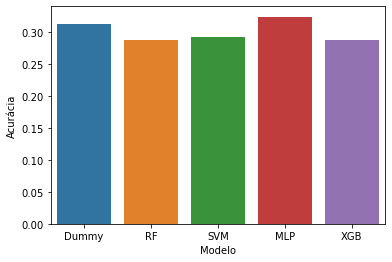

Modelo  Acurácia
0  Dummy  0.311741
1     RF  0.287449
2    SVM  0.291498
3    MLP  0.323887
4    XGB  0.287449

In [7]:
# Avaliando os modelos para cada dado com o treino
avalia_dif_modelos_cv(X_train1, y_train1, 5)

In [8]:
avalia_dif_modelos_cv(X_train2, y_train2, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.30      0.36      0.33        84
           2       0.30      0.53      0.39        85

    accuracy                           0.30       247
   macro avg       0.20      0.30      0.24       247
weighted avg       0.21      0.30      0.24       247

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73        78
           1       0.53      0.39      0.45        84
           2       0.69      0.79      0.74        85

    accuracy                           0.65       247
   macro avg       0.64      0.65      0.64       247
weighted avg       0.64      0.65      0.64       247

-------------------

Modelo  Acurácia
0  Dummy  0.303644
1     RF  0.651822
2    SVM  0.680162
3    MLP  0.595142
4    XGB  0.651822

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.15      0.19        80
           1       0.29      0.35      0.32        82
           2       0.31      0.36      0.34        85

    accuracy                           0.29       247
   macro avg       0.28      0.29      0.28       247
weighted avg       0.28      0.29      0.28       247

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.21      0.22        80
           1       0.33      0.38      0.35        82
           2       0.36      0.34      0.35        85

    accuracy                           0.31       247
   macro avg       0.31      0.31      0.31       247
weighted avg       0.31      0.31      0.31       247

-------------------

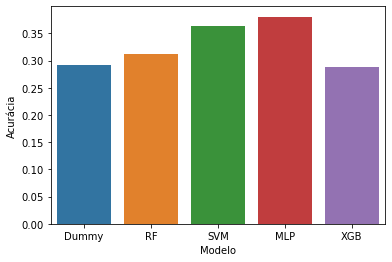

Modelo  Acurácia
0  Dummy  0.291498
1     RF  0.311741
2    SVM  0.364372
3    MLP  0.380567
4    XGB  0.287449

In [9]:
avalia_dif_modelos_cv(X_train3, y_train3, 5)

In [10]:
avalia_dif_modelos_cv(X_train4, y_train4, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.74      0.46        89
           1       0.00      0.00      0.00        76
           2       0.22      0.13      0.17        82

    accuracy                           0.31       247
   macro avg       0.19      0.29      0.21       247
weighted avg       0.19      0.31      0.22       247

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84        89
           1       0.67      0.57      0.61        76
           2       0.77      0.88      0.82        82

    accuracy                           0.77       247
   macro avg       0.76      0.76      0.76       247
weighted avg       0.76      0.77      0.76       247

-------------------

Modelo  Acurácia
0  Dummy  0.311741
1     RF  0.769231
2    SVM  0.700405
3    MLP  0.623482
4    XGB  0.728745

In [11]:
# Definindo parametros:
# Definir os modelos e os grids de parâmetros
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'MLP': MLPClassifier(),
    'XGBoost': XGBClassifier()
}

param_grids = [
    {
        'model': 'Random Forest',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    },
    {
        'model': 'SVM',
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': ['scale', 'auto']
        }
    },
    {
        'model': 'MLP',
        'params': {
            'hidden_layer_sizes': [(10,), (50,), (100,), (150,), (200,)],
            'activation': ['logistic', 'tanh', 'relu'],
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
            'learning_rate': ['constant', 'invscaling', 'adaptive']
        }
    },
    {
        'model': 'XGBoost',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [3, 5, 7, 9, 11],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
    }
]





In [12]:
# Criando uma função para avaliar os modelos
def avalia_modelo_cv(model, X_input, y_input, n, resultados_individuais=False):
    kf = KFold(n_splits=n)
    reports = []
    y_true = []
    y_pred_list = []
    X_array = X_input.values
    accuracy_list = []
    model_name = type(model).__name__
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_input)):
        X_train, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_input[train_index], y_input[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_true.extend(y_test)
        y_pred_list.append(y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        reports.append(report)
        accuracy_list.append(accuracy_score(y_test, y_pred))
        if resultados_individuais:
            print(f"Classification Report for fold {fold_idx + 1}:\n{report}\n")
    y_pred_total = np.concatenate(y_pred_list)
    print("-" * 45)
    print("model_name: ", model_name)
    print("Average Classification Report:")
    avg_report = classification_report(y_true, y_pred_total, zero_division=0)
    print(avg_report)
    #Retorna a acuracia media
    return accuracy_score(y_true, y_pred_total)

In [13]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_predict
import numpy as np


def perform_cross_validation(model, X, y, cv, verbose=True):
    reports = []
    predictions = cross_val_predict(model, X, y, cv=cv)

    for fold in range(cv):
        start = fold * len(X) // cv
        end = (fold + 1) * len(X) // cv
        report = classification_report(y[start:end], predictions[start:end], output_dict=True)
        reports.append(report)

        if verbose:
            print(f"Fold {fold + 1} Classification Report:")
            print(classification_report(y[start:end], predictions[start:end]))
            print("-" * 50)

    avg_report = {
        'precision': np.mean([report['weighted avg']['precision'] for report in reports]),
        'recall': np.mean([report['weighted avg']['recall'] for report in reports]),
        'f1-score': np.mean([report['weighted avg']['f1-score'] for report in reports]),
        'support': np.mean([report['weighted avg']['support'] for report in reports])
    }

    accuracy = accuracy_score(y, predictions)

    if verbose or not verbose:
        print("Average Classification Report:")
        print(classification_report(y, predictions))
        print("-" * 50)
        print(f"Accuracy: {accuracy:.2f}")

    return None


In [14]:
# Chamando função para cada uma das bases
# Aplicando Random Forest no under-sampling com Cross Validation de 10 folds
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
model = RandomForestClassifier()
modelSVM = SVC()
#avalia_modelo_cv(model, data1_re, target1_re, 5, True)

perform_cross_validation(model, data1_re, target1_re, 5, True)



Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60        61
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.43        61
   macro avg       0.33      0.14      0.20        61
weighted avg       1.00      0.43      0.60        61

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.38      0.46        42
           1       0.41      0.35      0.38        20
           2       0.00      0.00      0.00         0

    accuracy                           0.37        62
   macro avg       0.33      0.24      0.28        62
weighted avg       0.53      0.37      0.44        62

--------------------------------------------------
Fold 3 Classification Report:
              precision    recall  f1-score   

In [15]:
perform_cross_validation(model, data2_re, target2_re, 5, True)


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        61
           1       0.00      0.00      0.00         0

    accuracy                           0.85        61
   macro avg       0.50      0.43      0.46        61
weighted avg       1.00      0.85      0.92        61

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.79        42
           1       0.41      0.35      0.38        20
           2       0.00      0.00      0.00         0

    accuracy                           0.61        62
   macro avg       0.42      0.36      0.39        62
weighted avg       0.72      0.61      0.66        62

--------------------------------------------------
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00  

In [16]:
model_rf = RandomForestClassifier(n_jobs=-1)
perform_cross_validation(model_rf, data3_re, target3_re, 5, True)

Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60        61
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.43        61
   macro avg       0.33      0.14      0.20        61
weighted avg       1.00      0.43      0.60        61

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.24      0.33        42
           1       0.21      0.20      0.21        20
           2       0.00      0.00      0.00         0

    accuracy                           0.23        62
   macro avg       0.26      0.15      0.18        62
weighted avg       0.44      0.23      0.29        62

--------------------------------------------------
Fold 3 Classification Report:
              precision    recall  f1-score   

In [17]:
perform_cross_validation(model, data4_re, target4_re, 5, True)

Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        61
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.87        61
   macro avg       0.33      0.29      0.31        61
weighted avg       1.00      0.87      0.93        61

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74        42
           1       0.44      0.60      0.51        20
           2       0.00      0.00      0.00         0

    accuracy                           0.61        62
   macro avg       0.46      0.41      0.42        62
weighted avg       0.77      0.61      0.67        62

--------------------------------------------------
Fold 3 Classification Report:
              precision    recall  f1-score   

In [24]:
# Chamando função para cada uma das bases
print("========================== Data 1  =================================")
best_models1, modelo1 = perform_model_tuning(data1, target1, models, param_grids, "data1")
#print("========================== Data 2  =================================")
best_models2, modelo2 = perform_model_tuning(data2, target2, models, param_grids,"data2")
#print("========================== Data 3  =================================")
best_models3, modelo3 = perform_model_tuning(data3, target3, models, param_grids, "data3")
print("========================== Data 4  =================================")
best_models4, modelo4 = perform_model_tuning(data4, target4, models, param_grids, "data4")

========================== Data 1  =================================
Tuning do modelo Random Forest iniciado...
Acurácia do modelo Random Forest: 0.7029
Tuning do modelo SVM iniciado...
Acurácia do modelo SVM: 0.6914
Tuning do modelo MLP iniciado...
Acurácia do modelo MLP: 0.6857
Tuning do modelo XGBoost iniciado...
Acurácia do modelo XGBoost: 0.6400
Tuning do modelo Random Forest iniciado...
Acurácia do modelo Random Forest: 0.7371
Tuning do modelo SVM iniciado...
Acurácia do modelo SVM: 0.7257
Tuning do modelo MLP iniciado...
Acurácia do modelo MLP: 0.7029
Tuning do modelo XGBoost iniciado...
Acurácia do modelo XGBoost: 0.7429
Tuning do modelo Random Forest iniciado...
Acurácia do modelo Random Forest: 0.6914
Tuning do modelo SVM iniciado...
Acurácia do modelo SVM: 0.6914
Tuning do modelo MLP iniciado...
Acurácia do modelo MLP: 0.6857
Tuning do modelo XGBoost iniciado...
Acurácia do modelo XGBoost: 0.6400
========================== Data 4  =================================
Tuning do 

In [20]:
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [25]:
# Pegar o melhor modelo de cada base, usando max, para em seguida aplicar SBFS e SFFS com cross validation
# para cada um dos modelos
#best_model1 = max(best_models1, key=best_models1.get)
#modelo1 = best_models1['Random Forest']

#best_model2 = max(best_models2, key=best_models2.get)
#modelo2 = best_models2['Random Forest']

#best_model3 = max(best_models3, key=best_models3.get)
#modelo3 = best_models3['Random Forest']

#best_model4 = max(best_models4, key=best_models4.get)
#modelo4 = best_models4['Random Forest']

print(modelo1)
print(modelo2)
print(modelo3)
print(modelo4)

RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=50)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=4,
                       min_samples_spli

In [ ]:
# Salvando modelo1 à 4 em pickle
import pickle
with open('modelo1.pkl', 'wb') as f:
    pickle.dump(modelo1, f)
with open('modelo2.pkl', 'wb') as f:
    pickle.dump(modelo2, f)
with open('modelo3.pkl', 'wb') as f:
    pickle.dump(modelo3, f)
with open('modelo4.pkl', 'wb') as f:
    pickle.dump(modelo4, f)

In [4]:
# # Importando modelos pickl
import pickle
with open('data1_best_model.pkl', 'rb') as file:
    modelo1 = pickle.load(file)
print(f'Modelo1 = \n{modelo1}')
with open('data2_best_model.pkl', 'rb') as file:
    modelo2 = pickle.load(file)
print(f'Modelo2 = \n{modelo2}')
with open('data3_best_model.pkl', 'rb') as file:
    modelo3 = pickle.load(file)
print(f'Modelo3 = \n{modelo3}')
with open('data4_best_model.pkl', 'rb') as file:
    modelo4 = pickle.load(file)
print(f'Modelo4 = \n{modelo4}')

Modelo1 = 
RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=50)
Modelo2 = 
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
Modelo3 = 
RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=4,
      

In [26]:
#Analisar cross validation para cada um dos modelos
print("========================== Data 1  =================================")
c1 = cross_val_score(modelo1, data1_re, target1_re , cv=5)
print(c1)
print(c1.mean())

perform_cross_validation(modelo1, data1_re, target1_re, 5, True)

========================== Data 1  =================================
[0.30645161 0.30645161 0.37096774 0.29032258 0.37704918]
0.3302485457429931
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.41      0.58        61
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.41        61
   macro avg       0.33      0.14      0.19        61
weighted avg       1.00      0.41      0.58        61

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.29      0.41        42
           1       0.41      0.45      0.43        20
           2       0.00      0.00      0.00         0

    accuracy                           0.34        62
   macro avg       0.39      0.25      0.28        62
weighted avg       0.64      0.34    

In [27]:
print("========================== Data 2  =================================")
c2 = cross_val_score(modelo2, data2_re, target2_re, cv=5)
print(c2)
print(c2.mean())

perform_cross_validation(modelo2, data2_re, target2_re, 5, True)

========================== Data 2  =================================
[0.66129032 0.69354839 0.74193548 0.62903226 0.6557377 ]
0.6763088313061871
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        61
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.75        61
   macro avg       0.33      0.25      0.29        61
weighted avg       1.00      0.75      0.86        61

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.67      0.74        42
           1       0.38      0.40      0.39        20
           2       0.00      0.00      0.00         0

    accuracy                           0.58        62
   macro avg       0.40      0.36      0.38        62
weighted avg       0.68      0.58    

In [28]:
print("========================== Data 3  =================================")
c3 = cross_val_score(modelo3, data3_re, target3_re, cv=5)
print(c3)
print(c3.mean())

perform_cross_validation(modelo3, data3_re, target3_re, 5, True)


========================== Data 3  =================================
[0.37096774 0.32258065 0.35483871 0.29032258 0.31147541]
0.33003701745108405
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.28      0.44        61
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.28        61
   macro avg       0.33      0.09      0.15        61
weighted avg       1.00      0.28      0.44        61

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.26      0.39        42
           1       0.30      0.40      0.34        20
           2       0.00      0.00      0.00         0

    accuracy                           0.31        62
   macro avg       0.34      0.22      0.24        62
weighted avg       0.59      0.31   

In [29]:
print("========================== Data 4  =================================")
c4 = cross_val_score(modelo4, data4_re, target4_re, cv=5)
print(c4)
print(c4.mean())

perform_cross_validation(modelo4, data4_re, target4_re, 5, True)

========================== Data 4  =================================
[0.85483871 0.77419355 0.75806452 0.66129032 0.72131148]
0.7539397144368059
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        61
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.85        61
   macro avg       0.33      0.28      0.31        61
weighted avg       1.00      0.85      0.92        61

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.67      0.77        42
           1       0.46      0.55      0.50        20
           2       0.00      0.00      0.00         0

    accuracy                           0.63        62
   macro avg       0.45      0.41      0.42        62
weighted avg       0.76      0.63    

In [15]:
import matplotlib.pyplot as plt

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Função para aplicar SBFS e SFFS com cross validation e salvar tabela com resultado.
def perform_feature_selection(data, target, model, best_model, method, cv):
    # Criando o objeto de seleção de features
    if method == 'SBFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=False,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=-1)
    elif method == 'SFFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=True,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=-1)
    # Aplicando o método de seleção de features
    sfs = sfs.fit(data, target)
    # Salvando o resultado em um dataframe
    df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    # Definindo nome do arquivo para salvar as features selecionadas em formato CSV
    if os.path.exists(f"results/{method}_{best_model}.csv"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.csv"):
            i += 1
        file_name_csv = f"results/{method}_{best_model}_{i}.csv"
    else:
        file_name_csv = f"results/{method}_{best_model}.csv"

    # Salvando o dataframe em um arquivo CSV
    df.to_csv(file_name_csv, index=False)

    # Definindo nome do arquivo para salvar as features selecionadas em formato TXT
    if os.path.exists(f"results/{method}_{best_model}.txt"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.txt"):
            i += 1
        file_name_txt = f"results/{method}_{best_model}_{i}.txt"
    else:
        file_name_txt = f"results/{method}_{best_model}.txt"

    # Salvando as features selecionadas e o score em um arquivo TXT
    with open(file_name_txt, 'w') as file:
        file.write(f"Selected Features: {', '.join(sfs.k_feature_names_)}\n")
        file.write(f"Score: {sfs.k_score_}")

    # Plotando o desempenho do modelo para cada combinação de atributos
    fig, ax = plt.subplots()
    ax.plot(range(1, len(df) + 1), df['avg_score'], marker='o')
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Average Score')
    ax.set_title('Performance of Model with Feature Selection')
    plt.xticks(range(1, len(df) + 1))
    plt.grid(True)

    # Definindo nome do arquivo para salvar o gráfico
    if os.path.exists(f"results/{method}_{best_model}.png"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.png"):
            i += 1
        file_name_plot = f"results/{method}_{best_model}_{i}.png"
    else:
        file_name_plot = f"results/{method}_{best_model}.png"

    # Salvando o gráfico em um arquivo PNG
    plt.savefig(file_name_plot)

    # Retornando as features selecionadas e o score
    return sfs.k_feature_names_, sfs.k_score_

In [1]:
!pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 974.9 kB/s eta 0:00:00a 0:00:01


In [ ]:
#Função que muda max_features de auto p sqrt se tiver definido para evitar erro de versão
def updt_maxfeature(modelo):
    try:
        if modelo.get_params()['max_features'] == 'auto':
            modelo.max_features = 'sqrt'
            print(modelo)
    except:
        pass


updt_maxfeature(modelo1)
updt_maxfeature(modelo2)
updt_maxfeature(modelo3)
updt_maxfeature(modelo4)

========================== Data 1  =================================


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    2.8s finished

[2023-09-04 17:52:38] Features: 53/1 -- score: 0.6245714285714286[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    1.9s finished

[2023-09-04 17:52:40] Features: 52/1 -- score: 0.626863711001642[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished

[2023-09-04 17:52:42] Features: 51/1 -- score: 0.6257077175697865[Parallel(n_jobs=-1)]: Us

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

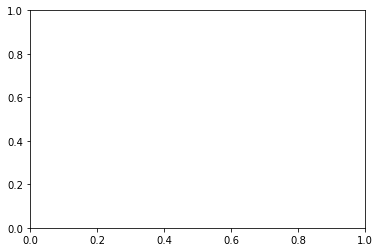

In [17]:
# Chamando a função de feature selection para cada um dos "modelos*"
print("========================== Data 1  =================================")
slt_sbfs_features1, score1_sbfs = perform_feature_selection(data1, target1, modelo1, "data1", 'SBFS', 5)
slt_sffs_features1, score1_sffs = perform_feature_selection(data1, target1, modelo1, "data1", 'SFFS', 5)
print("========================== Data 2  =================================")
slt_sbfs_features2, score2_sbfs = perform_feature_selection(data2, target2, modelo2, "data2", 'SBFS', 5)
slt_sffs_features2, score2_sffs = perform_feature_selection(data2, target2, modelo2,"data2", 'SFFS', 5)
print("========================== Data 3  =================================")
slt_sbfs_features3, score3_sbfs = perform_feature_selection(data3, target3, modelo3, "data3", 'SBFS', 5)
slt_sffs_features3, score3_sffs = perform_feature_selection(data3, target3, modelo3, "data3", 'SFFS', 5)
print("========================== Data 4  =================================")
slt_sbfs_features4, score4_sbfs = perform_feature_selection(data4, target4, modelo4,"data4", 'SBFS', 5)
slt_sffs_features4, score4_sffs = perform_feature_selection(data4, target4, modelo4, "data4", 'SFFS', 5)

In [ ]:
# Criando um arquivo txt com a feature selecionadas
with open(f"results/SBFS_data1.txt", "w") as f:
    f.write(str(slt_sbfs_features1))
with open(f"results/SFFS_data1.txt", "w") as f:
    f.write(str(slt_sffs_features1))
with open(f"results/SBFS_data2.txt", "w") as f:
    f.write(str(slt_sbfs_features2))
with open(f"results/SFFS_data2.txt", "w") as f:
    f.write(str(slt_sffs_features2))
with open(f"results/SBFS_data3.txt", "w") as f:
    f.write(str(slt_sbfs_features3))
with open(f"results/SFFS_data3.txt", "w") as f:
    f.write(str(slt_sffs_features3))
with open(f"results/SBFS_data4.txt", "w") as f:
    f.write(str(slt_sbfs_features4))
with open(f"results/SFFS_data4.txt", "w") as f:
    f.write(str(slt_sffs_features4))

In [ ]:
# Testando os modelos com as features selecionadas
print("========================== Data 1  - SBFS =================================")
perform_cross_validation(modelo1, data1_re.loc[:,slt_sbfs_features1], target1_re, 5, False)

print("========================== Data 1  - SFFS =================================")
perform_cross_validation(modelo1, data1_re.loc[:,slt_sffs_features1], target1_re, 5, False)

print("========================== Data 2  - SBFS =================================")
perform_cross_validation(modelo2, data2_re.loc[:,slt_sbfs_features2], target2_re, 5, False)

print("========================== Data 2  - SFFS =================================")
perform_cross_validation(modelo2, data2_re.loc[:,slt_sffs_features2], target2_re, 5, False)

print("========================== Data 3  - SBFS =================================")
perform_cross_validation(modelo3, data3_re.loc[:,slt_sbfs_features3], target3_re, 5, False)

print("========================== Data 3  - SFFS =================================")
perform_cross_validation(modelo3, data3_re.loc[:,slt_sffs_features3], target3_re, 5, False)

print("========================== Data 4  - SBFS =================================")
perform_cross_validation(modelo4, data4_re.loc[:,slt_sbfs_features4], target4_re, 5, False)

print("========================== Data 4  - SFFS =================================")
perform_cross_validation(modelo4, data4_re.loc[:,slt_sffs_features4], target4_re, 5, False)

In [ ]:

#print("========================== Data 1  =================================")
#X_train, X_test, y_train, y_test = train_test_split(data1, target1, test_size=0.2)
#tpot = TPOTClassifier(verbosity=2, config_dict='TPOT light')
#tpot.fit(X_train, y_train)
#accuracy = tpot.score(X_test, y_test)
#print(f"Acurácia do melhor modelo encontrado: {accuracy}")
#tpot.export('tpot_best_model1.py')
#print("========================== Data 2  =================================")
#X_train, X_test, y_train, y_test = train_test_split(data2, target2, test_size=0.2)
#tpot2 = TPOTClassifier(verbosity=2, config_dict='TPOT light')
#tpot2.fit(X_train, y_train)
#accuracy = tpot2.score(X_test, y_test)
#print(f"Acurácia do melhor modelo encontrado: {accuracy}")
##tpot2.export('tpot_best_model2.py')
#print("========================== Data 3  =================================")
#X_train, X_test, y_train, y_test = train_test_split(data3, target3, test_size=0.2)
#tpot3 = TPOTClassifier(verbosity=2, config_dict='TPOT light')
#tpot3.fit(X_train, y_train)
#accuracy = tpot3.score(X_test, y_test)
#print(f"Acurácia do melhor modelo encontrado: {accuracy}")
#tpot3.export('tpot_best_model3.py')
#print("========================== Data 4  =================================")
#X_train, X_test, y_train, y_test = train_test_split(data4, target4, test_size=0.2)
#$tpot4 = TPOTClassifier(verbosity=2,config_dict='TPOT light')
#tpot4.fit(X_train, y_train)
#accuracy = tpot4.score(X_test, y_test)
#print(f"Acurácia do melhor modelo encontrado: {accuracy}")
#tpot4.export('tpot_best_model4.py')